In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:22<00:00, 7.74MB/s]


In [5]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
classes = trainset.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


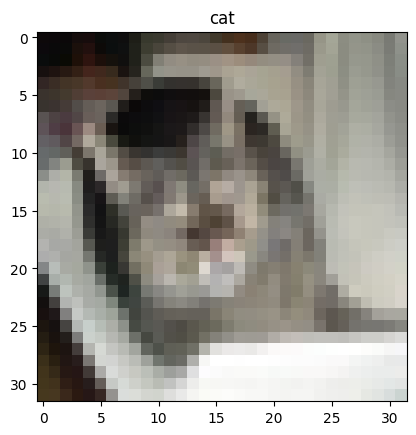

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
img = torch.permute(images[0], (1, 2, 0))
plt.imshow((img * 0.5 + 0.5).numpy())
plt.title(classes[labels[0]])
plt.show()

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # (in_channels, out_channels, kernel_size)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 8, 8]
        x = x.view(-1, 64 * 8 * 8)            # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(trainloader):.4f}")

print("✅ Training finished!")

Epoch [1/5] - Loss: 1.3561
Epoch [2/5] - Loss: 0.9715
Epoch [3/5] - Loss: 0.8181
Epoch [4/5] - Loss: 0.7089
Epoch [5/5] - Loss: 0.6136
✅ Training finished!


In [12]:
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"🎯 Test Accuracy: {100 * correct / total:.2f}%")

🎯 Test Accuracy: 69.74%


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

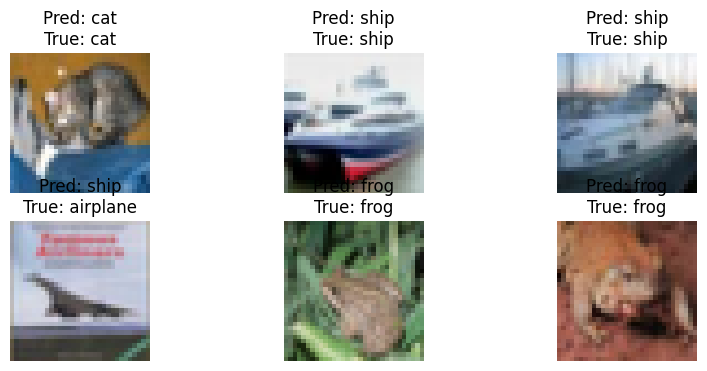

In [14]:
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    img = torch.permute(images[i].cpu(), (1,2,0))
    plt.imshow((img * 0.5 + 0.5).numpy())
    plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
    plt.axis('off')
plt.show()